In [38]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import time
import math
from numba import jit

%matplotlib notebook

## Simulated data for block trial structure

<IPython.core.display.Javascript object>


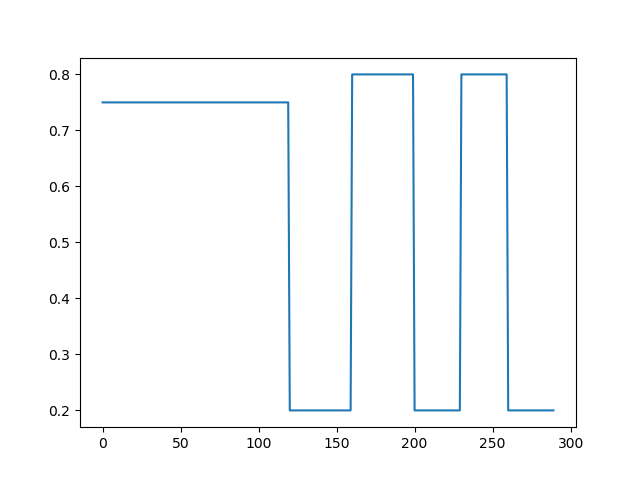

In [145]:
# Generate fake data from the model
# Build the true reward rate
true_prob = [0.75] * 120 + [0.2] * 40 + [0.8] * 40 + [0.2] * 30 + [0.8] * 30 + [0.2] * 30
plt.figure()
plt.plot(true_prob)

<IPython.core.display.Javascript object>


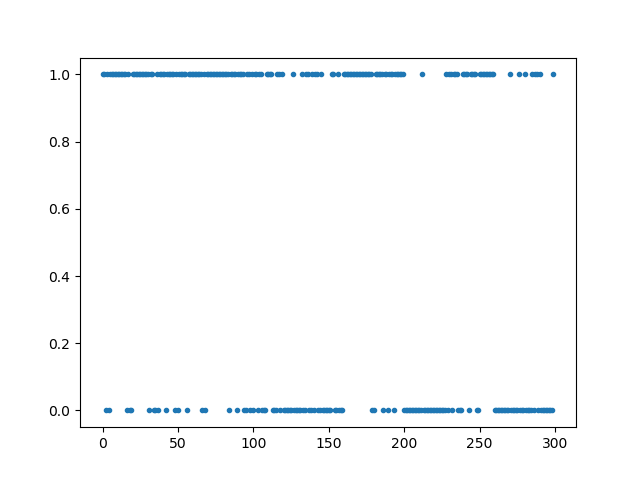

In [142]:
# Generate data from bernoulli
randvars = np.random.random(len(true_prob))
outcomes = randvars < true_prob
plt.figure()
plt.plot(outcomes, '.')

## Exact inference

In [4]:
# Define some conditionals that will be useful
@jit(nopython=True)
def my_beta(x, a, b):
    #print('beta', x, a, b)
    constant = math.gamma(a + b) / math.gamma(a) / math.gamma(b)
    return constant * x**(a - 1) * (1 - x)**(b - 1)
@jit(nopython=True)
def my_normal(x, mu, sigma):
    constant = 1 / np.sqrt(2 * np.pi * sigma**2)
    return np.exp(-(x - mu)**2 / 2 / sigma**2) * constant

# Test these
xvals = np.linspace(0, 1, 1000)
my_result = my_beta(xvals, 3, 4)
sts_result = sts.beta.pdf(xvals, 3, 4)

my_normal = my_normal(xvals, 3, 4)
sts_normal = sts.norm.pdf(xvals, 3, 4)


print('Beta test error: ', np.sum((sts_result - my_result)**2))
print('Normal test error: ', np.sum((sts_normal - my_normal)**2))

Beta test error:  2.6138349401201225e-28
Normal test error:  4.7955655615242173e-32


In [5]:
#@jit(nopython=True)
def pr_next(rnext, rprev, v):
    '''Find p(r_{i+1} = rnext | r_i = rprev, v)'''
    
    
    # Take care of boundaries:
    if len(np.shape(rnext)) == 0:
        size = 1
    else:
        size = len(rnext)
    rval = np.maximum(rnext, 1e-10)
    rval = np.minimum(rval, (1 - 1e-10))
                  
    s = rprev * np.exp(-v)
    n = (1 - rprev) * np.exp(-v)
    
    if s == 0:
        s = 1e-10
    if n == 0:
        n = 1e-10
    #print(s, n)
    
    # Math range error if use my_beta
    return sts.beta.pdf(rval, s, n)

@jit(nopython=True)
def pv_next(vnext, vprev, k):
    '''Find p(v_{i+1} = vnext | v_i = vprev, k)'''
    K = np.exp(k)
    mu = vprev
    sigma = K
    x = vnext
    constant = 1 / np.sqrt(2 * np.pi * sigma**2)
    return np.exp(-(x - mu)**2 / 2 / sigma**2) * constant
    #return my_normal(vnext, vprev, K) #sts.norm.pdf(vnext, vprev, K)

@jit(nopython=True)
def py_given_r(y, r):
    '''p(y = y| r), which is bernoulli'''
    assert(r <= 1 and r >= 0)
    assert(y == 1 or y == 0)
    if y == 1:
        return r
    else:
        return 1 - r

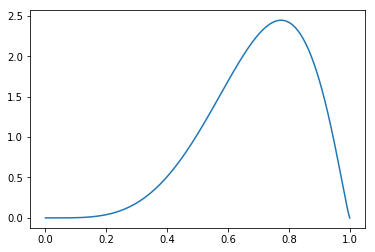

In [6]:
xvals = np.linspace(0, 1, 1000)
vprev = 0.7
probs = pr_next(xvals, vprev, -2)
plt.figure()
plt.plot(xvals, probs)
#plt.ylim([0, 0.1])
#plt.vlines(vprev, 0, 1)

In [122]:
# Set up a grid of r, v, k
rvals = np.linspace(1e-10, 1 - 1e-10, 10)
vvals = np.linspace(-3, 3, 10)
kvals = np.linspace(-3, 3, 10)
rgrid, vgrid, kgrid = np.meshgrid(rvals, vvals, kvals, indexing='ij')
grid_info = {'rvals': rvals, 'vvals': vvals, 'kvals': kvals}

#print(r, v, k, i)
dv = vvals[1] - vvals[0]
dr = rvals[1] - rvals[0]


# Set up the probability grid
posterior_arr = np.ones_like(rgrid)

In [87]:
# Use recursion to find the posterior
#@jit
def find_posterior_fast(nr, nv, nk, y, i, results):
    '''Find the posterior p(r_{i}, v_{i}, k | y_{<=i})
    Inputs:
    - r: value of r_{i+1}
    - v: value of v_{i+1}
    - k: value of k
    - y: array of y responses
    - i: time point'''
    
    # Check if answer is in results
    if results[nr][nv][nk][i] >= 0:
        return results[nr][nv][nk][i]
    
    
    else:
        # Base case
        if i == 0:
            results[nr][nv][nk][i] = 1
            return 1 # Uniform prior

        # Recursive step
        r = rvals[nr]
        k = kvals[nk]
        v = vvals[nv]
        
        p_yr = py_given_r(y[i - 1], r)

        # Do the integral
        integral = 0
        for nri, ri in enumerate(rvals):
            p_rv = pr_next(r, ri, v)
            #print('p_rv:', r, ri, v, p_rv)

            # Inner integral
            inner = 0
            for nvi, vi in enumerate(vvals):
                p_vk = pv_next(v, vi, k)
                posterior_prev = find_posterior_fast(nri, nvi, nk, y, i - 1, results)
                inner += posterior_prev * p_vk * dv

            integral += inner * p_rv * dr
        
        results[nr][nv][nk][i] = integral * p_yr
        #print('Results for ', r, v, k, i, ': ', integral)
        return integral * p_yr
    

In [124]:
def find_posterior_t_vec(nr, nv, nk, y, prev_res):
    '''Inputs:
    - nr, nv, nk: indices of the r, v, k desired
    - prev_res: Nr x Nv x Nk array encoding posterior at time t - 1
    - Returns the posterior at time t corresponding to nr, nv, nk'''
    r = rvals[nr]
    k = kvals[nk]
    v = vvals[nv]
    
    p_yr = py_given_r(y, r)
    #print(p_yr)
    # Do the integral
    integral = 0
    for nri, ri in enumerate(rvals):
        p_rv = pr_next(r, ri, v)
        #print('p_rv:', r, ri, v, p_rv)

        # Inner integral
        p_vk = pv_next(v, vvals, k)
        posterior_prev = prev_res[nri,:,nk]
        #print(p_vk)
        #print(posterior_prev)
        inner = np.sum(posterior_prev * p_vk) * dv
        #print(np.sum(posterior_prev * p_vk), dv)
        integral += inner * p_rv * dr
        #print(integral)
    #print(integral)
    return integral * p_yr

In [120]:
def find_posterior_t_arr(y, prev_res):
    '''Inputs:
    - prev_res: Nr x Nv x Nk array encoding posterior at time t - 1
    - Returns the Nr x Nv x Nk array encoding posterior at time t'''
    result = np.zeros_like(prev_res)
    for nr in range(len(rvals)):
        for nv in range(len(vvals)):
            for nk in range(len(kvals)):
                result[nr, nv, nk] = find_posterior_t_vec(nr, nv, nk, y, prev_res)
    # Normalize
    result = result / np.sum(result)
    return result

In [ ]:
begin = time.time()
#outcomes = np.random.rand(100) < 0.5
result_final = np.ones((10, 10, 10, len(outcomes))) / 1000
for t in range(len(outcomes) - 1):
    print(t)
    result = find_posterior_t_arr(outcomes[t], result_final[:,:,:,t])
    result_final[:,:,:,t+1] = result
end = time.time()
print('Elapsed time is ', end - begin)

0
1
2
3


In [99]:
find_posterior_t_arr(outcomes[0], result_final[:,:,:,0])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


array([[[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],

       [[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan,

In [30]:
results = np.ones((len(rvals), len(vvals), len(kvals), len(outcomes))) * -1

start = time.time()
for t in range(100):
    print(t)
    for ir, r1 in enumerate(rvals):
        for iv, v1 in enumerate(vvals):
            for im, k1 in enumerate(kvals):
                find_posterior_fast(ir, iv, im, outcomes, t, results)
                #print(ir, iv, im, t, results[0,0,0,1])
    
    # Normalize 
    results[:,:,:,t] = results[:,:,:,t] / np.sum(results[:,:,:,t])
    
end = time.time()
print('Elapsed time is ', end - start)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Elapsed time is  109.00653171539307


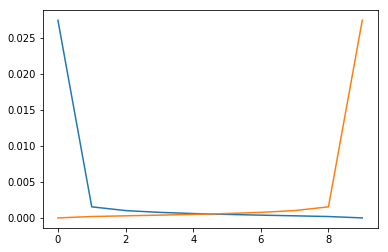

In [13]:
plt.plot(result_final[:,3,0,1])
plt.plot(results[:,3,0,1])

<IPython.core.display.Javascript object>


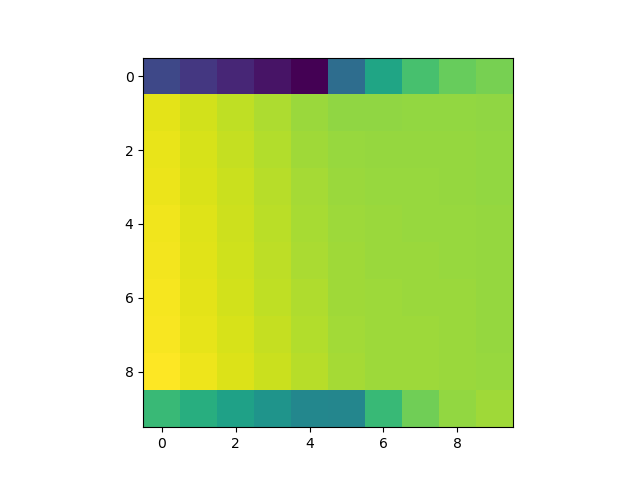

In [68]:
plt.figure()
plt.imshow(np.log(results[:,:,1,40]))

## Evolution of the parameters

In [134]:
rprobs = []
vprobs = []
kprobs = []

for t in range(len(outcomes)):
    endres = result_final[:,:,:,t]
    # Marginalize out v and k
    r_prob = np.sum(endres, axis=(1,2))[1:9]
    v_prob = np.sum(endres, axis=(0,2))
    k_prob = np.sum(endres, axis=(0,1))
    
    # Expectations
    expR = np.sum(r_prob / np.sum(r_prob) * rvals[1:9])
    expV = np.sum(v_prob / np.sum(v_prob) * vvals)
    expK = np.sum(k_prob / np.sum(k_prob) * kvals)
    
    rprobs.append(expR)
    vprobs.append(expV)
    kprobs.append(expK)
    

<IPython.core.display.Javascript object>


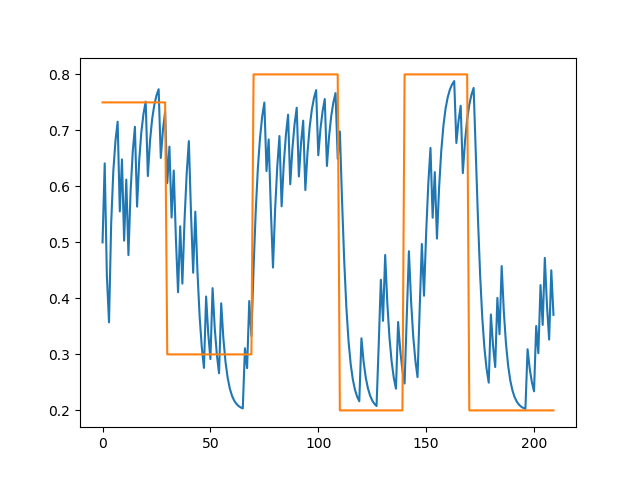

In [136]:
plt.figure()
plt.plot(rprobs)
plt.plot(true_prob)

<IPython.core.display.Javascript object>


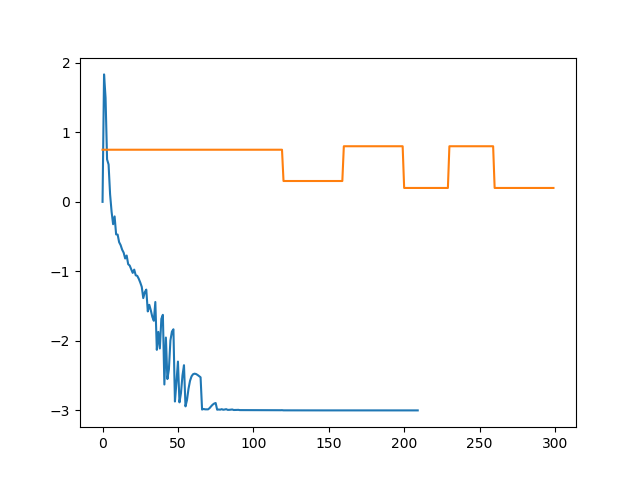

In [138]:
plt.figure()
plt.plot(vprobs)
#plt.plot(true_prob)

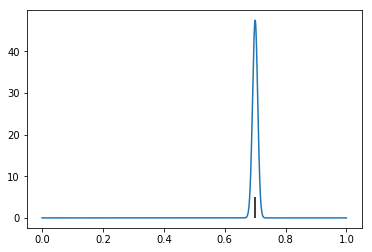

In [20]:
ri = 0.7
xvals = np.linspace(0,1,1000)
probs = sts.beta.pdf(xvals, ri * np.exp(8), (1 - ri) * np.exp(8))

plt.figure()
plt.plot(xvals, probs)
plt.vlines(0.7, ymin=0, ymax=5)